### Import the GitHub Project

In [34]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project

Cloning into 'project'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 186 (delta 11), reused 13 (delta 5), pack-reused 164
Receiving objects: 100% (186/186), 36.06 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [35]:
!rm -rf sample_data

### Install Dependencies
---
- pytorch (1.12.1)
- torchvision (0.13.1)
---
- pytorch3d
---
- SMPL
- chumpy

In [36]:
import os
import sys

In [37]:
# install torch
try:
    import torch
    if torch.__version__ != "1.12.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# install torchvision
try:
    import torchvision
    if torchvision.__version__ != "0.13.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torchvision==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# install pytorch3d
import torch, torchvision

try:
    import pytorch3d
except ModuleNotFoundError:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install pytorch3d

In [40]:
# install SMPL dependencies
!pip install smplpytorch
!pip install chumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### GPU

In [41]:
torch.cuda.is_available()

True

In [42]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [43]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

### Local Imports 

In [45]:
from project.smpl import SMPL, TexturesFactory, mesh_from
from project.rendering import CamerasFactory, Renderer
#from project.clipmodel import ClipModel

import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SMPL

In [52]:
# create SMPL layer
smpl_model = SMPL(model=None, device=dev) #model=None uses the default model
# params initalization
pose_params = torch.zeros(1, 72, device=dev) # theta
shape_params = torch.zeros(1, 10, device=dev) # beta
# compute vertices and faces
verts, faces = smpl_model.verts_and_faces(beta=shape_params, theta=pose_params)
# create a texture
txs_factory = TexturesFactory(device=dev)
texture = txs_factory.from_facecolor(nfaces=len(faces[0]), facecolor=0.5*np.ones(3, ))
# create the mesh
mesh = mesh_from(vertices=verts, faces=faces, texture=texture)

### Differentiable Renderer

In [75]:
# Create the Differentiable Renderer layer
camsfactory = CamerasFactory(device=dev)
cameras = camsfactory.fov_persp_scs(coords=(2.25, 0, 0), fov=60, frustrum_depth=(1, 100))
renderer = Renderer(device=dev, cameras=cameras)

images = renderer.render(mesh)

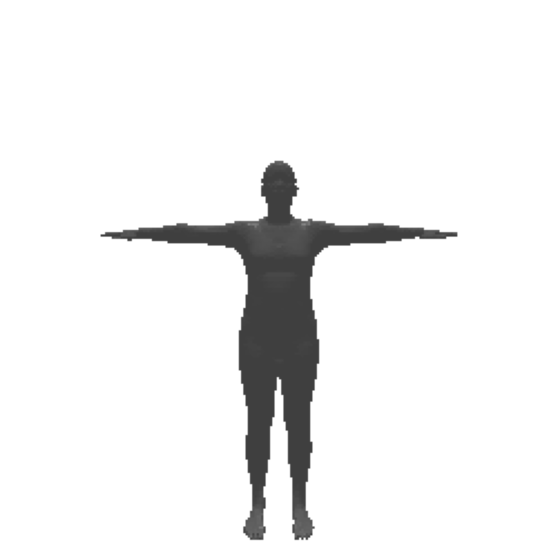

In [76]:
# a quick visualization of the rendering
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

### CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
from project.clipModel import ClipModel

clip_model = ClipModel(model="ViT-B/32")
prompt = "a man standing up" # for example

similarity = clip.get_cosine_similarity(images, prompt)

print("The similarity between the 3d model and the prompt",prompt,"are",similarity)